In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import catDict as cat
import plotStyle

In [11]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
pd.set_option('display.max_columns', None)

In [12]:
df = pd.read_csv('intencao-voto.csv', sep=';', encoding='latin1').drop(['Entrevistador', 'Unnamed: 30'], axis=1)
   
df.replace({r'\\"':'', '\[': '', ']': ''}, regex=True, inplace=True)
df.columns = df.columns.str.lower()

for col in df.columns:
    chars = ''.join([cat.remove_especial_chars()['chars'](x) for x in col])
    df.rename(columns={col:chars}, inplace=True)

In [13]:
df.drop('voto exp', axis=1).head()

,tem titulo,votou,sexo,idade,escolaridade,religiao,renda ind,renda familia,interesse,voto ind,rejeicao,rejeicao 2,rejeicao partido,rejeicao partido 2,avaliacao adm,aprovacao adm,area maior problema,area maior problema 2,area maior problema 3,caracteristica politica,fonte de informacao,adm bolsonaro,apoio bolsonaro,adm zema,apoio zema,vota filiado pt,latitude,longitude
0,1,1,1,4,4,1,2,2,2,1,2,5,10,6,3,2,2,7,3,Dedicação,não soube,3,1,3,1,2,-20.364933333333333,-42.11351
1,1,1,2,6,2,1,7,8,1,2,1,1,15,15,6,1,5,18,19,mostrar serviço,vendo os trabalhos,3,2,2,1,2,-20.365355,-42.113438333333335
2,1,1,2,2,4,1,1,1,2,2,1,1,16,16,2,1,21,21,21,ser verdadeiro,Conversas,3,1,3,1,2,-20.366081666666666,-42.113645
3,1,1,1,7,1,1,1,2,1,1,4,4,15,15,3,1,2,5,1,mostrar trabalho,sendo da comunidade,3,2,3,1,2,-20.36629,-42.11268
4,1,1,2,5,2,1,7,8,3,2,1,1,15,15,1,1,8,21,21,honesto,pela comunidade,5,2,3,1,1,-20.368188333333332,-42.11293666666667


In [14]:
for n, value in enumerate(df['caracteristica politica']):
    df.loc[n, 'caracteristica politica'] = ''.join([cat.remove_especial_chars()['chars'](x) for x in value.lower().strip()])
for n, value in enumerate(df['fonte de informacao']):
    df.loc[n, 'fonte de informacao'] = ''.join([cat.remove_especial_chars()['chars'](x) for x in value.lower().strip()])

In [15]:
df[['renda familia', 'interesse', 'vota filiado pt']] = df[['renda familia', 'interesse', 'vota filiado pt']].astype('int8')
cols = df.select_dtypes('number').columns
df[cols] = df[cols].astype('category')

### Análise de intenção de voto por  candidato por variável simples

In [16]:
def my_autopct(pct):
    return ('%.2f' % pct) + '%' if pct > 2 else None

In [17]:
def plotar_desagredado(var='sexo', colors=30):
    
    serie = pd.Series([cat.cats()[var](x) for x in df[var]]).astype('category')
    serie2 = pd.Series([cat.cats()['voto ind'](x) for x in df['voto ind']]).astype('category')
    df_desag = df.groupby([serie2, serie]).count()[['tem titulo']]
    df_desag = df_desag.transpose()
    
    index_cand = df_desag.columns.get_level_values(0).categories
    index_var = df_desag.columns.get_level_values(1).categories
    
    nc = len(index_cand) 
    nv = len(index_var) 
    
    b = dict()
    for bar in index_cand: #eixo y (%)
        b[bar] = round((df_desag.loc['tem titulo'][bar] / df_desag.loc['tem titulo'][bar].sum())*100, 1)
    
    b = pd.DataFrame(b)
    width = 1/(nv*2)
    
    plotStyle.dark_theme()
    
    chart = list()
    color_list = list(matplotlib.colors.cnames.values())
    dist = 0 #distancia de uma barra para a outra do mesmo grupo
    cluster = 0 #distancia de grupo de barras para outro
    for cand in b.columns:
        cluster += width*nv
        color = colors
        for value in b.index.categories:
            chart.append(plt.bar(((width*nv)/2)+dist+cluster, b.loc[value, cand], 
                                             width=width, color=color_list[color], align='center'))
            color+=1
            dist+=width
    
    for bar in chart:
        plt.bar_label(bar, label_type='edge', fontsize=8, color='yellow')  
    
    plt.ylabel('(%)', color='white')
    plt.title(f'Intenção de votos em cada candidato, por {var}', color='white')
    plt.xticks(range(1, nc+1, 1), index_cand, rotation=45, color='white')
    plt.yticks(range(0, 100, 10), color='white')
    plt.legend(index_var, fontsize=8)
    plt.show()

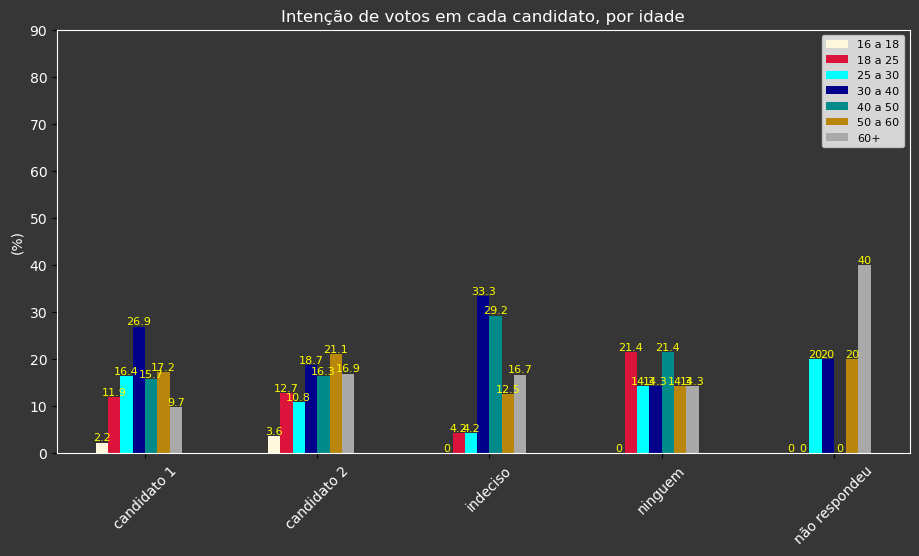

In [18]:
plotar_desagredado(var='idade', colors=18)

### Análise de intenção de voto pelo cruzamento de duas variáveis

In [19]:
def cruzamento_2variaveis(var='sexo', var_2='idade', showdata=False):
    check_zeros = lambda x : '' if x==0 else x

    df_2var = df[['tem titulo', 'voto ind', var, var_2]].groupby(['voto ind', var, var_2]).count().transpose()
    var2 = dict()# apresentar os grupos em porcentagem dentro de cada categoria da variavel a cima
    for var0 in df_2var.columns.get_level_values(0).categories:
        dict_pct = dict()
        for var1 in df_2var.columns.get_level_values(1).categories:
            dict_pct[var1] = [round((i/df_2var[var0][var1].values.sum())*100, 2) for i in list(df_2var[var0][var1].unstack().values)]
        var2[var0] = dict_pct

    df_detail = pd.DataFrame.from_dict({(i, j): var2[i][j]
                              for i in var2.keys()
                              for j in var2[i].keys()}, orient='index').transpose()
    df_detail.columns=pd.MultiIndex.from_tuples(df_detail.columns)

    def unique_labels(i, c, c2):
        return i if c==1 and c2==1 else None
    if showdata:
        return df_detail
    else:
        color_list = list(matplotlib.colors.cnames)
        fig, ax = plt.subplots(figsize=(10,6))
        category = cat.cats()[var_2]
        nc = len(df_detail.columns.get_level_values(0).astype('category').categories)
        nv = len(df_detail.columns.get_level_values(1).astype('category').categories)
        width = 1
        cluster = -(width*nv)

        for c in df_detail.columns.get_level_values(0).unique():
            cluster+=(width*nv)
            dist=-width
            for c2 in df_detail.columns.get_level_values(1).unique():
                color = 10
                bottom = [0]*nv*nc
                dist+=width*0.95
                for i in df_detail.index:
                    chart = ax.bar(0.05+cluster+dist, df_detail[c].loc[i, c2], width=width, bottom=bottom[c-1], 
                                         color=color_list[color], align='center', label=category(unique_labels(i+1, c, c2)))
                    bottom[c-1]+=df_detail[c].loc[i, c2]
                    color+=1
                    plt.bar_label(chart, label_type='center', labels=[check_zeros(df_detail[c][c2][i])], fontsize=8, color='k')

        ax.set_title(f'Inteção de voto por {var} e {var_2}')
        ax.set_ylabel('(%)')
        ax.set_xlim(-0.5, 1.5*cluster)
        ax.set_xticks(np.linspace(0, cluster+dist, nc*nv), 
                       [cat.cats()[var](x) for x in df_detail.columns.get_level_values(1)], rotation=90)
        ax.legend(fontsize=8)
        ax.grid(visible=True, color='gray', alpha=0.5)

        plt.show()

<ipython-input-19-4032c4885d4e>:9: RuntimeWarning: invalid value encountered in longlong_scalars
  dict_pct[var1] = [round((i/df_2var[var0][var1].values.sum())*100, 2) for i in list(df_2var[var0][var1].unstack().values)]


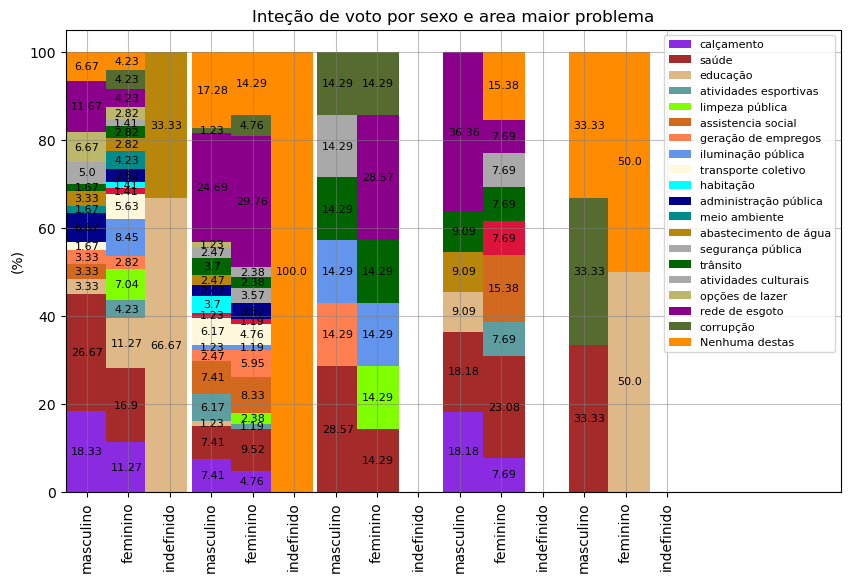

In [20]:
cruzamento_2variaveis(var='sexo', var_2='area maior problema', showdata=False)

In [21]:
df_cruzado = cruzamento_2variaveis(var='sexo', var_2='renda ind', showdata=True)

<ipython-input-19-4032c4885d4e>:9: RuntimeWarning: invalid value encountered in longlong_scalars
  dict_pct[var1] = [round((i/df_2var[var0][var1].values.sum())*100, 2) for i in list(df_2var[var0][var1].unstack().values)]


In [22]:
from seaborn import heatmap

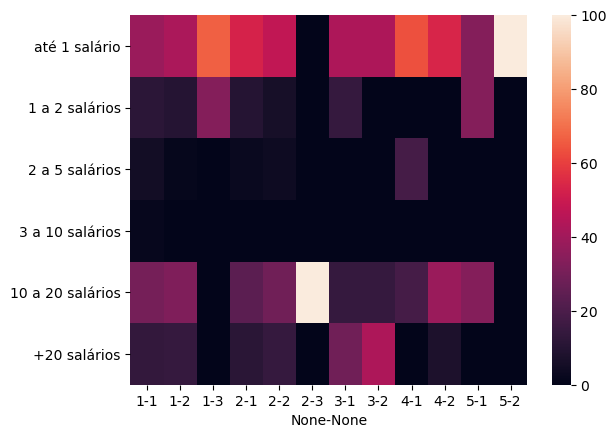

In [23]:
heatmap(df_cruzado.dropna(axis=1, how='all'), yticklabels=[cat.cats()['renda ind'](x+1) for x in df_cruzado.index])
plt.show()